<a href="https://colab.research.google.com/github/DimaKav/python-marketing-projects/blob/master/Predicting_and_Analyzing_the_Drivers_of_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data set (telco) includes the following features:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [0]:
!pip install matplotlib==3.1.0
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

# Data Loading and Preprocessing

In [0]:
# Load dataset
telco_raw = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-for-marketing-projects/master/telco.csv')
# Replace the blank spaces with NaN
telco_raw.replace(" ", pd.np.nan, inplace=True)
# Make total charges be a numeric dtype
telco_raw['TotalCharges'] = pd.to_numeric(telco_raw['TotalCharges'])
# Fill the NaNs with the mean of TotalCharges
telco_raw.fillna(2283, inplace=True)

In [0]:
telco_raw.shape

(7043, 21)

In [0]:
telco_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.299972
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [0]:
telco_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Visualizations

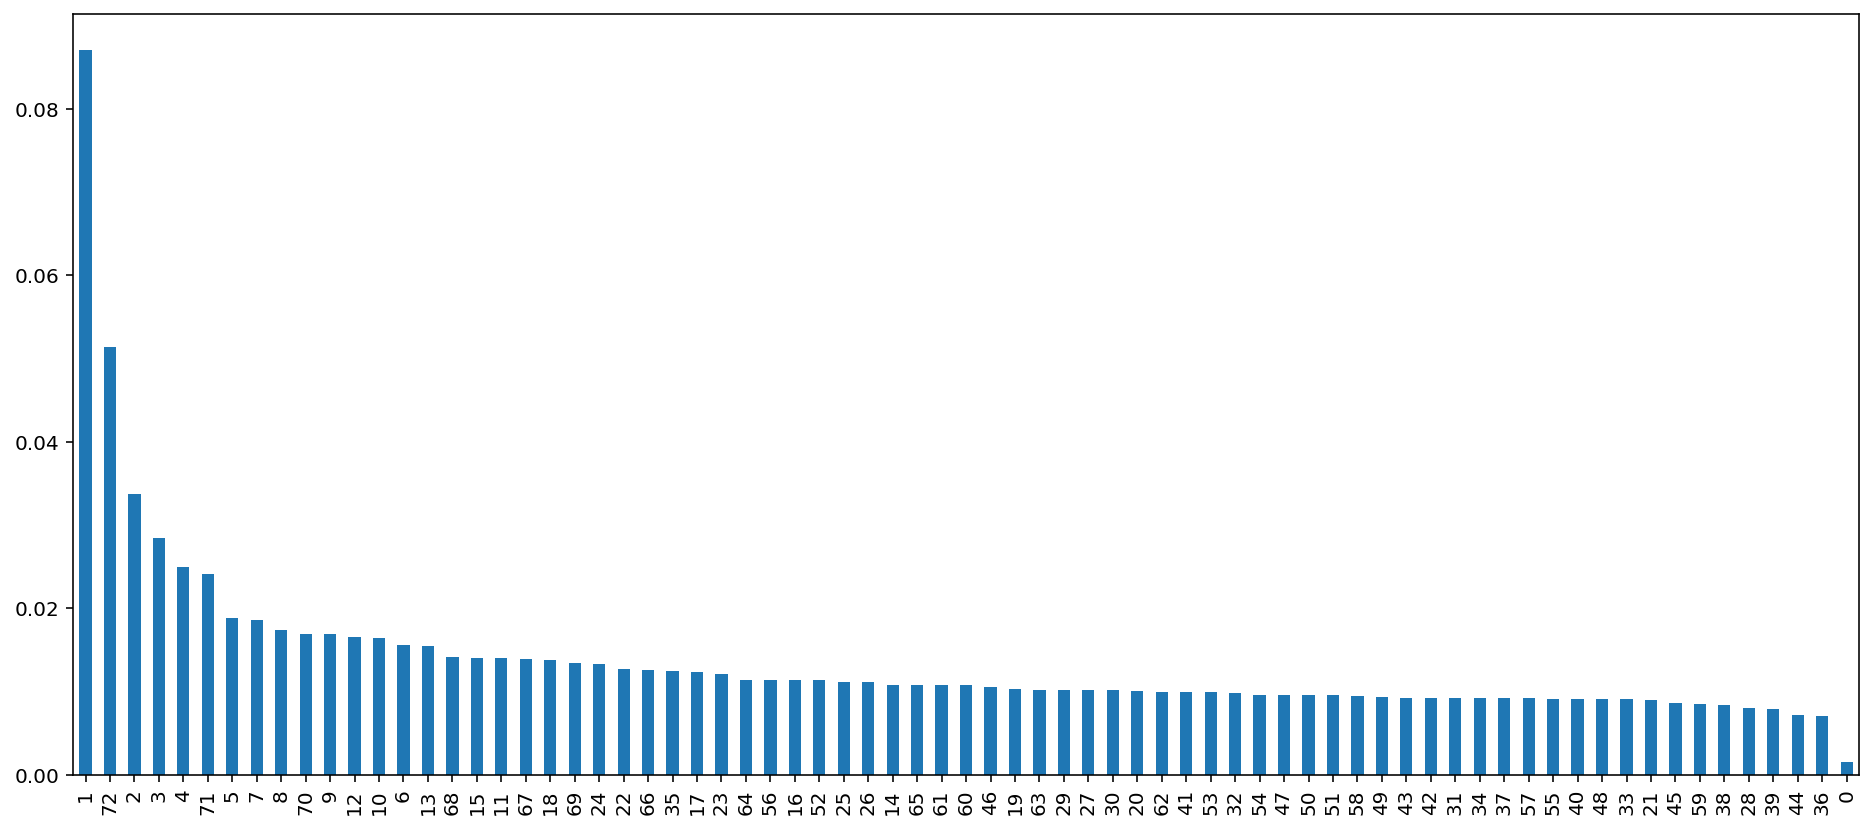

In [0]:
# Distribution of Tenure (months)
telco_raw.tenure.value_counts(normalize=True).plot(kind='bar',figsize=(16,7));

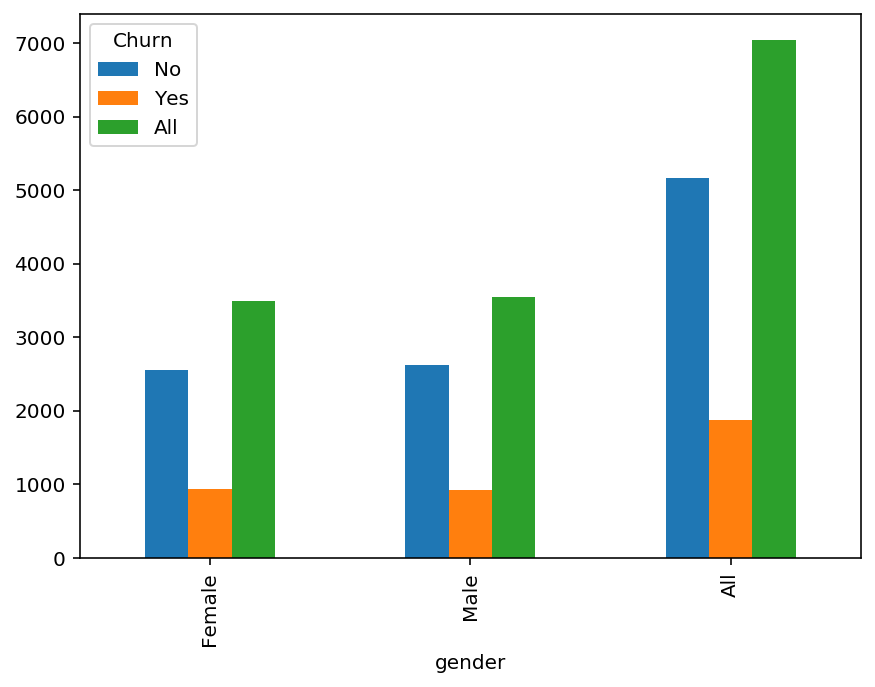

In [0]:
# Churn by gender
pd.crosstab(telco_raw.gender,telco_raw.Churn,margins=True).plot(kind='bar',figsize=(7,5));

It looks like gender has very little effect on churn since the number are nearly the same for both males and females.

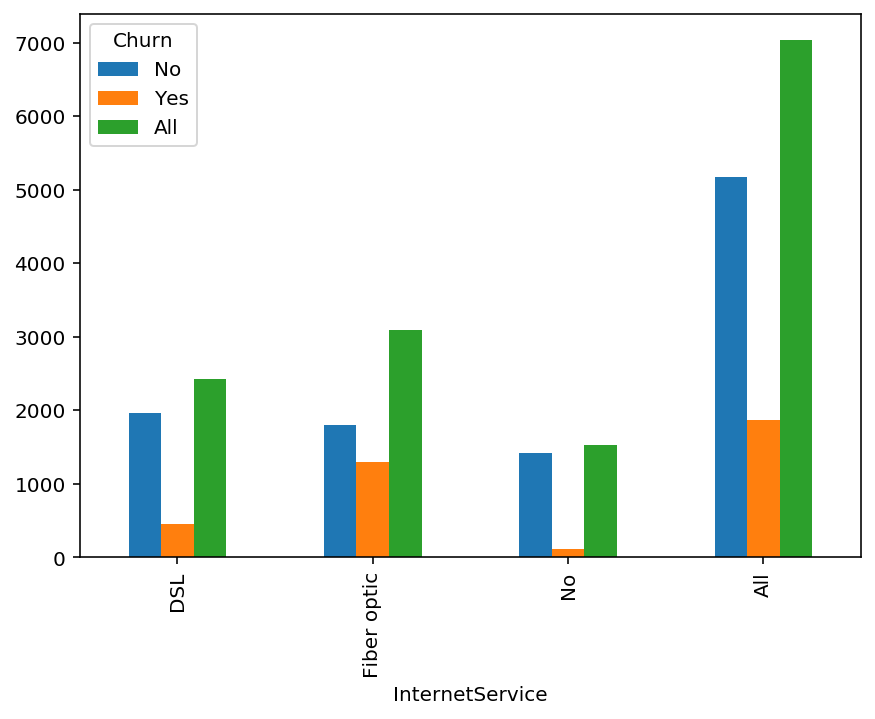

In [0]:
pd.crosstab(telco_raw.InternetService,telco_raw.Churn,margins=True).plot(kind='bar',figsize=(7,5));

People with fiber optic service are likely to churn.

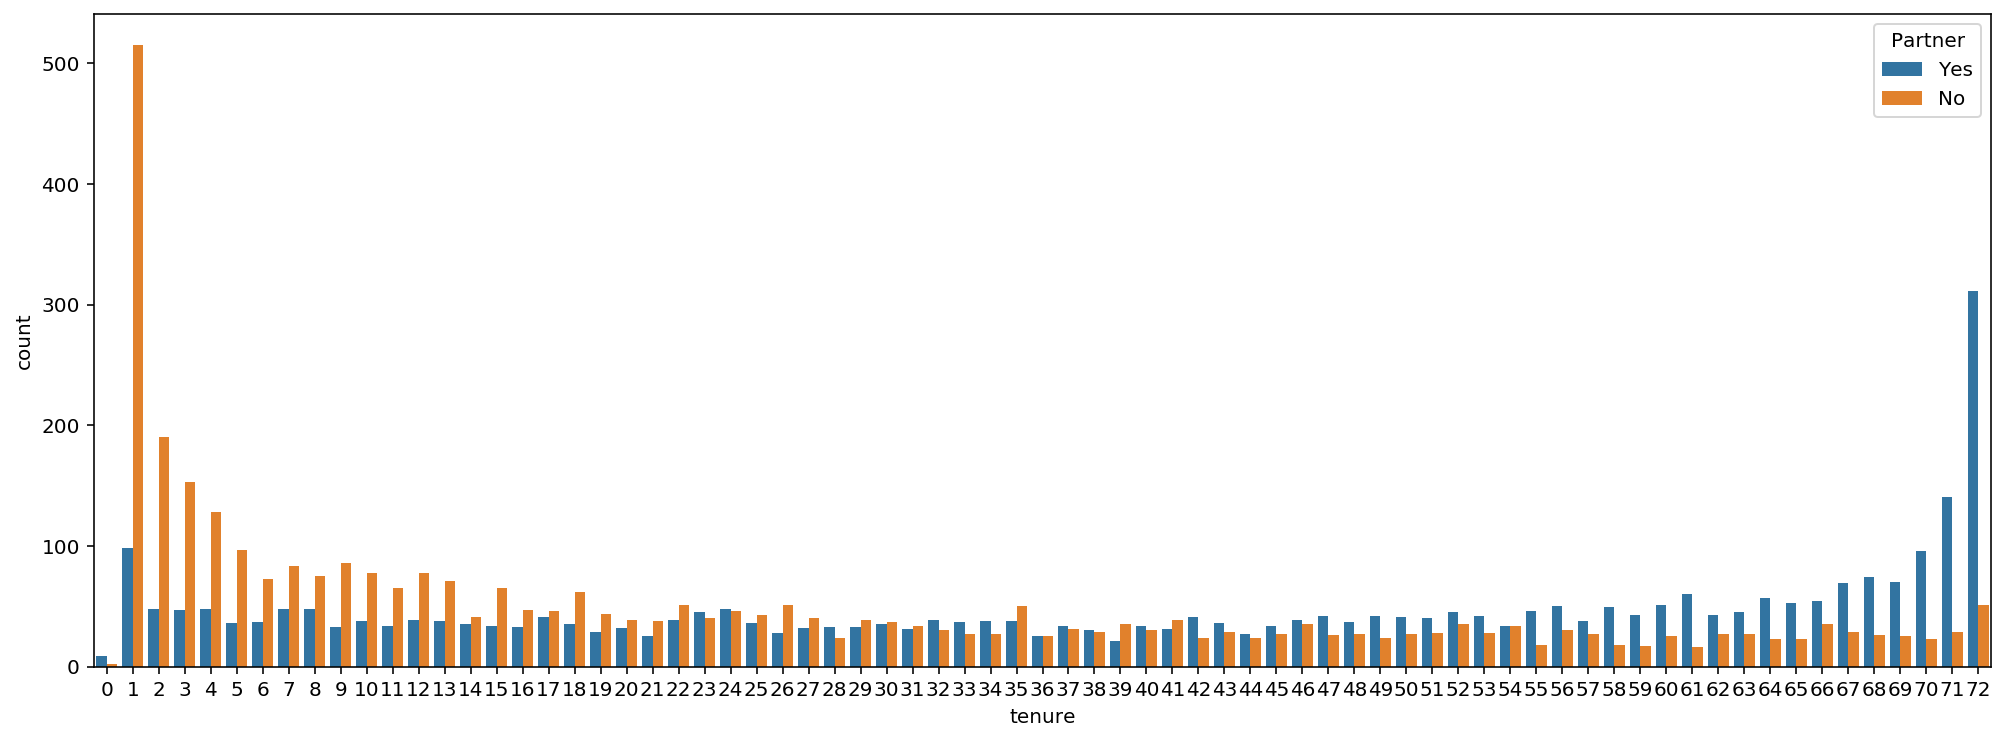

In [0]:
plt.figure(figsize=(17,6))
sns.countplot(x=telco_raw['tenure'],hue=telco_raw.Partner);

People with partners tend to stay longer with the company. To see more linear correlations, we'll make a heatmap.

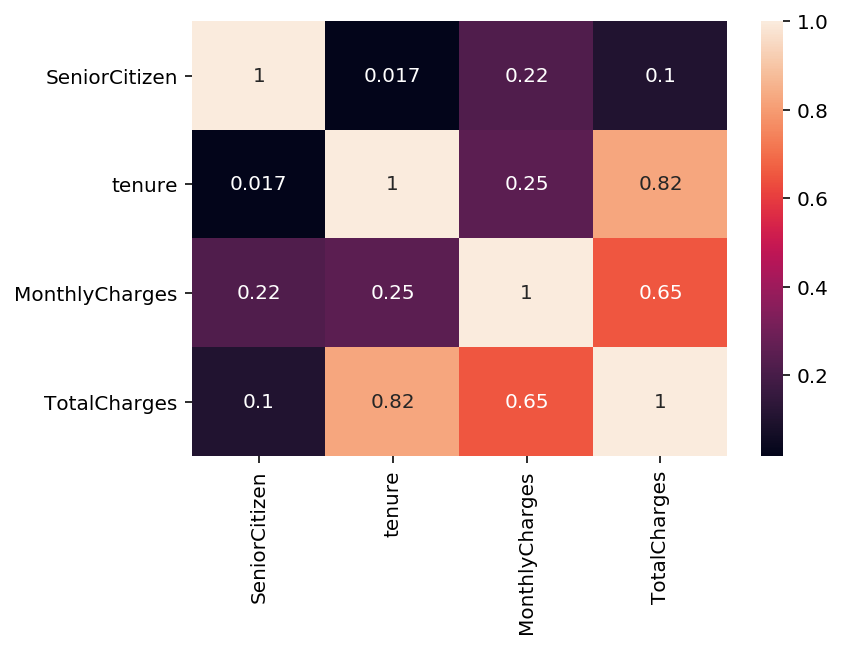

In [0]:
sns.heatmap(telco_raw.corr(),xticklabels=telco_raw.corr().columns.values,yticklabels=telco_raw.corr().columns.values,annot=True);

To gain a better understanding of strong effects on churn, we will build a predictive model and see which features have the most effect.

# Predicting Churn
Churn is when a customer stops buying a product or stops engaging with a product or application. Churn can be voluntary or involuntary. Involuntary churn happens when a customer's subscription ends due to credit card expiration or other blockers.

Types of churn:
* Contractual - when customers decide to cancel service.
* Non-contractual - one example is when customers stop buying groceries. These types of churn are harder to define. We can say that for groceries, churn might be when a customer stops buying groceries for one month. In order to define this type of churn, we have to track the purchasing patterns of the specific customer.



In [0]:
telco_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
telco_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [0]:
# Check the cardinality of each feature
telco_raw.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [0]:
# Store customerID and Churn column names
custid = ['customerID']
target = ['Churn']

# Store categorical column names
categorical = telco_raw.nunique()[telco_raw.nunique() < 5].keys().tolist()

# Remove target from the list of categorical variables
categorical.remove(target[0])

# Store numerical column names
numerical = [x for x in telco_raw.columns if x not in custid + target + categorical]

# Perform one-hot encoding to categorical variables 
telco_raw = pd.get_dummies(data = telco_raw, columns = categorical, drop_first=True)

# Initialize StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on numerical columns
scaled_numerical = scaler.fit_transform(telco_raw[numerical])

# Build a DataFrame from scaled_numerical
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

# Drop non scaled numerical columns
telco_raw = telco_raw.drop(columns=numerical, axis=1)

# Merge the non-numerical with the scaled numerical data
telco = telco_raw.merge(right=scaled_numerical, how='left', left_index=True,
                        right_index=True)

In [0]:
telco.shape

(7043, 32)

In [0]:
# Define target and predictors
X = telco.drop(['customerID','Churn'], 1)
y = telco['Churn']

# Split X and Y into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Ensure training dataset has only 75% of original X data
print(X_train.shape[0] / X.shape[0])

# Ensure testing dataset has only 25% of original X data
print(X_test.shape[0] / X.shape[0])

0.7499645037626012
0.25003549623739885


In [0]:
# Initialize logistic regression instance 
logreg = LogisticRegression(solver='lbfgs')

# Fit the model on training data
logreg.fit(X_train, y_train)

# Predict churn values on test data
pred_test_Y = logreg.predict(X_test)

# Print the accuracy score on test data
print('Test accuracy:', round(accuracy_score(y_test, pred_test_Y), 4))

Test accuracy: 0.8018


# Main Drivers of Churn

To see and understand drivers of churn, we will use the coefficients from our logistic regression model. These beta coefficients can be interpreted as change in log-odds of churn associated with a 1 unit increase in the feature. To get the actual change in odds (not log odds), we'll have to calculate the exponent of the coefficients which will give us the change in odds associated with a 1 unit increase in the feature.

In [0]:
# Combine feature names and coefficients into pandas DataFrame
feature_names = pd.DataFrame(X_train.columns, columns=['Feature'])
log_coef = pd.DataFrame(pd.np.transpose(logreg.coef_), columns=['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)

# Calculate exponent of the logistic regression coefficients
coefficients['Exp_Coefficient'] = pd.np.exp(coefficients['Coefficient'])

# Remove coefficients that are equal to zero
coefficients = coefficients[coefficients['Coefficient']!=0]

# Print the values sorted by the exponent coefficient
print(coefficients.sort_values(by=['Exp_Coefficient']))

                                  Feature  Coefficient  Exp_Coefficient
27                                 tenure    -1.447168         0.235236
22                      Contract_Two year    -1.399338         0.246760
21                      Contract_One year    -0.648692         0.522729
10                     OnlineSecurity_Yes    -0.467849         0.626348
4                        PhoneService_Yes    -0.231525         0.793323
16                        TechSupport_Yes    -0.220491         0.802125
26             PaymentMethod_Mailed check    -0.215633         0.806031
12                       OnlineBackup_Yes    -0.166990         0.846208
28                         MonthlyCharges    -0.143722         0.866128
13   DeviceProtection_No internet service    -0.131377         0.876887
9      OnlineSecurity_No internet service    -0.131377         0.876887
17        StreamingTV_No internet service    -0.131377         0.876887
15        TechSupport_No internet service    -0.131377         0

Exploring the coefficients allows us to see which features had the most negative and the most positive effects on churn.